In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_tools import *
from datetime import datetime
from nls_optimizer import *
from my_time_series import tests_gaussian_white_noise

In [4]:
def day_of_year(date_string):
    # Convert string to datetime object
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    # Get the day of the year
    day_of_year = date_object.timetuple().tm_yday
    return day_of_year

### Load Data

In [5]:
dam_id = 169

path = from_id_to_time_series(dam_id)

ts = pd.read_csv(path)

ele_ts = pd.read_csv('electricity_prices_caiso_np15.csv')
ele_ts.Date = ele_ts.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
ele_ts = ele_ts.set_index('Date')
ele_ts = ele_ts / 100
ele_ts = ele_ts.rename(columns= {'price': 'power_price'})

In [32]:
pd.read_csv("electricity_data_clean.csv")

,date,price
0,2015-05-19 00:27:30.000000000,27.930100
1,2015-05-19 01:27:30.000000000,-12.878828
2,2015-05-19 02:27:30.000000000,-63.371210
3,2015-05-19 03:27:30.000000000,-16.610445
4,2015-05-19 04:27:30.000000000,22.740565
...,...,...
78886,2024-05-18 19:27:30.000000000,23.467767
78887,2024-05-18 20:27:30.000000000,23.696278
78888,2024-05-18 21:27:30.000000000,15.703146
78889,2024-05-18 22:27:30.000000000,13.962254


In [23]:
ele_ts = pd.read_csv('electricity_data.csv')

ele_ts['date'] = pd.to_datetime(ele_ts['date'])

ele_ts['hour'] = ele_ts['date'].dt.floor('h')

ele_ts = ele_ts.groupby('hour').mean()

In [24]:
ele_ts

,date,price
hour,,
2015-05-19 00:00:00,2015-05-19 00:27:30,27.930100
2015-05-19 01:00:00,2015-05-19 01:27:30,-12.878828
2015-05-19 02:00:00,2015-05-19 02:27:30,-63.371210
2015-05-19 03:00:00,2015-05-19 03:27:30,-16.610445
2015-05-19 04:00:00,2015-05-19 04:27:30,22.740565
...,...,...
2024-05-18 19:00:00,2024-05-18 19:27:30,23.467767
2024-05-18 20:00:00,2024-05-18 20:27:30,23.696278
2024-05-18 21:00:00,2024-05-18 21:27:30,15.703146


### Models

In [7]:
def model_inflow(coefs_inflow, t):
    return coefs_inflow[0] + coefs_inflow[1] * (np.sin((t+coefs_inflow[2])*2*np.pi/365))

def model_price_e(coefs_prices_e,t,prev):
    return coefs_prices_e[1] * (coefs_prices_e[0] - prev)  + coefs_prices_e[2] * (np.sin((t+coefs_prices_e[3])*2*np.pi/6)) + coefs_prices_e[4] * (np.sin((t+coefs_prices_e[5])*2*np.pi/12))

In [8]:
inflows = ts.inflow.values
times   = np.arange(0 + 1,len(inflows) + 1,1) # + 1 because it starts in January 1st

observed_values = np.logical_not(np.isnan(inflows))
inflows = inflows[observed_values]
times   = times[observed_values]
times   = times[1:]

def residuals_inflow(coefs):
    return model_inflow(coefs, times) - inflows[1:]

num_coefs = 3
p0 = initial_values(num_coefs)
inflow_model = NLS(residuals_inflow, p0, xdata=times, ydata=inflows[1:])

print(inflow_model.summary())
# tests_gaussian_white_noise(inflow_model.mod1[2]['fvec'])
# plt.show()

Non-linear least squares
Model: residuals_inflow
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 6.9897   │ 0.1322     │ 52.8670 │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ 6.0807   │ 0.1872     │ 32.4892 │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 39.9459  │ 1.7840     │ 22.3908 │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  12.4783
R^2:  0.1059
Df: 8910
None


In [54]:
ele_ts = pd.read_csv('electricity_data_clean.csv')

Non-linear least squares
Model: residuals_ele
╒══════════╤═══════════╤════════════╤═══════════╤═════════╕
│ Variable │ Estimate  │ Std. Error │ t-value   │ P(>|t|) │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs0   │ -21.7326  │ 0.3321     │ -65.4440  │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs1   │ -0.6509   │ 0.0027     │ -240.7975 │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs2   │ -2.5322   │ 0.1929     │ -13.1292  │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs3   │ 1063.0386 │ 52.0802    │ 20.4116   │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs4   │ -3.3150   │ 0.1924     │ -17.2305  │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs5   │ 1654.7324 │ 80.0662    │ 20.6670   │ 0.0000  │
├──────────┼───────────┼────────────┼───────────┼─────────┤
│ coefs6   │ 3.3062    │ 0.1925     │ 17.1721   │ 0.00

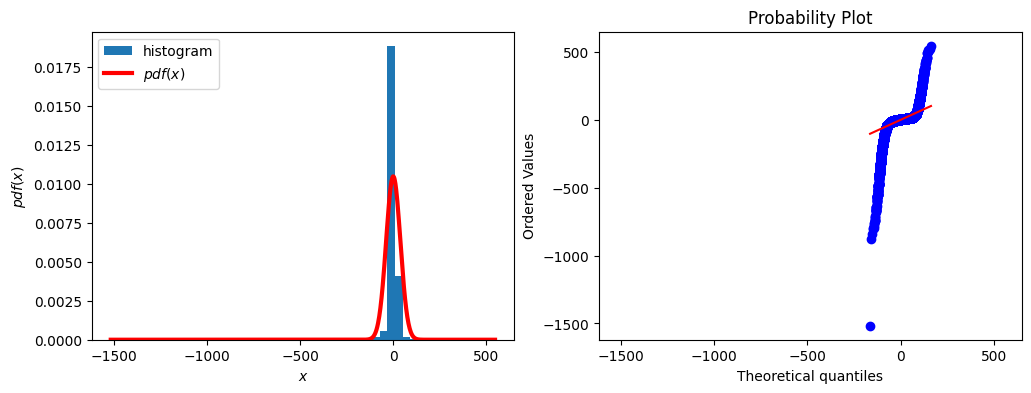

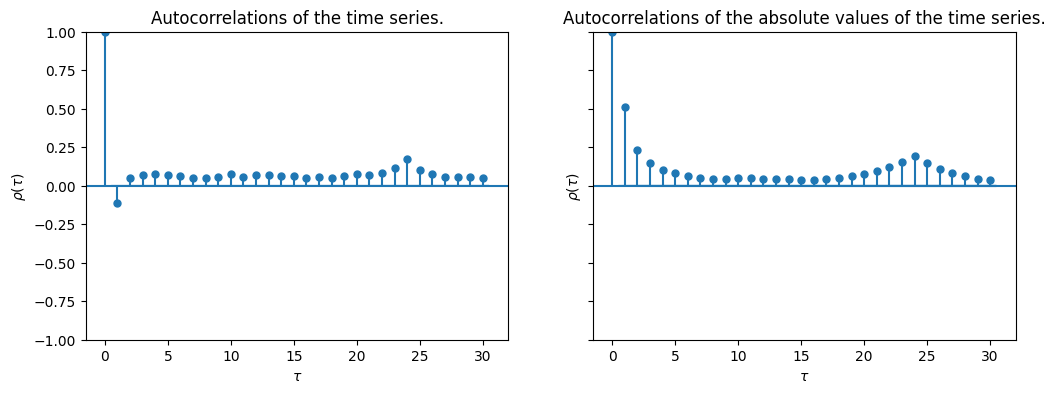

In [68]:
ele_prices = ele_ts.price.values
times      = np.arange(0+5,len(ele_prices)+5,1) # + 5 becauase the data starts in may

observed_values = np.logical_not(np.isnan(ele_prices))
ele_prices = ele_prices[observed_values]
times   = times[observed_values]
times   = times[1:]


def model_price_e(coefs_prices_e,t,prev):
    return (coefs_prices_e[1] * (coefs_prices_e[0] - prev) +
        coefs_prices_e[2] * np.sin((t + coefs_prices_e[3]) * 2 * np.pi / (6 * 30 * 24)) +
                             coefs_prices_e[4] * np.sin((t + coefs_prices_e[5]) * 2 * np.pi / (12 * 30 * 24)) +
                             coefs_prices_e[6] * np.sin((t + coefs_prices_e[7]) * 2 * np.pi / 24))

# def model_price_e(coefs_prices_e,t,prev):
#     return (coefs_prices_e[1] * (coefs_prices_e[0] - prev) +
#         coefs_prices_e[2] * np.sin((t + coefs_prices_e[3]) * 2 * np.pi / (6 * 30 * 24)) +
#                              coefs_prices_e[4] * np.sin((t + coefs_prices_e[5]) * 2 * np.pi / (12 * 30 * 24)) +
#                              coefs_prices_e[6] * (t%24 == 0) + 
#             coefs_prices_e[6+1] * (t%24 == 0+1) +
#            coefs_prices_e[6+2] * (t%24 == 0+2) +
#            coefs_prices_e[6+3] * (t%24 == 0+3) +
#            coefs_prices_e[6+4] * (t%24 == 0+4) +
#            coefs_prices_e[6+5] * (t%24 == 0+5) +
#            coefs_prices_e[6+6] * (t%24 == 0+6) +
#            coefs_prices_e[6+7] * (t%24 == 0+7) +
#            coefs_prices_e[6+8] * (t%24 == 0+8) +
#            coefs_prices_e[6+9] * (t%24 == 0+9) +
#            coefs_prices_e[6+10] * (t%24 == 0+10) +
#            coefs_prices_e[6+11] * (t%24 == 0+11) +
#            coefs_prices_e[6+12] * (t%24 == 0+12) +
#            coefs_prices_e[6+13] * (t%24 == 0+13) +
#            coefs_prices_e[6+14] * (t%24 == 0+14) +
#            coefs_prices_e[6+15] * (t%24 == 0+15) +
#            coefs_prices_e[6+16] * (t%24 == 0+16) +
#            coefs_prices_e[6+17] * (t%24 == 0+17) +
#            coefs_prices_e[6+18] * (t%24 == 0+18) +
#            coefs_prices_e[6+19] * (t%24 == 0+19) +
#            coefs_prices_e[6+20] * (t%24 == 0+20) +
#            coefs_prices_e[6+21] * (t%24 == 0+21) +
#            coefs_prices_e[6+22] * (t%24 == 0+22) )


def residuals_ele(coefs):
    return model_price_e(coefs, times, ele_prices[:-1]) - ele_prices[1:]

# num_coefs = 29
num_coefs = 8
p0 = initial_values(num_coefs)
ele_model = NLS(residuals_ele, p0, xdata=times, ydata=ele_prices[1:])

print(ele_model.summary())
tests_gaussian_white_noise(ele_model.mod1[2]['fvec'])
plt.show()

In [79]:
cofficients_inflow = inflow_model.parmEsts
coefficients_electricity = ele_model.parmEsts

sd_inflow      = inflow_model.mod1[2]['fvec'].std()
sd_electricity = ele_model.mod1[2]['fvec'].std()

def model_inflow_forecast(t):
    return cofficients_inflow[0] + cofficients_inflow[1] * (np.sin((t+cofficients_inflow[2])*2*np.pi/365))

def model_price_e_forecast(t,prev, shock):
    return coefficients_electricity[1] * (coefficients_electricity[0] - prev)  + coefficients_electricity[2] * (np.sin((t+coefficients_electricity[3])*2*np.pi/6)) \
    + coefficients_electricity[4] * (np.sin((t+coefficients_electricity[5])*2*np.pi/12)) + sd_inflow * shock

In [58]:
observed_storage = np.logical_not(ts.storage.isna())
observed_inflow = np.logical_not(ts.inflow.isna())
observed_outflow = np.logical_not(ts.outflow.isna())

ts_observed = ts[np.logical_and(observed_storage, observed_inflow, observed_outflow)]

In [60]:
def model_inventory(inventory, inflow, outflow):
    return inventory - outflow + inflow

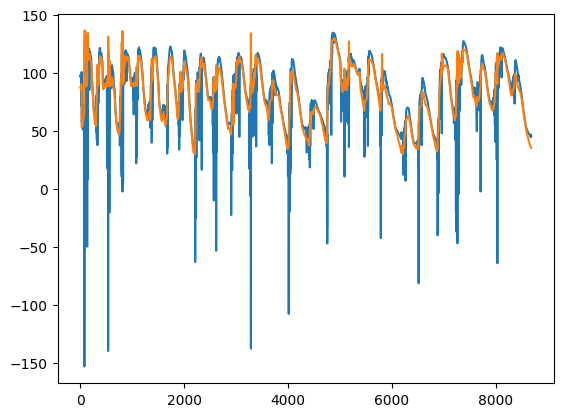

The std is: 14.19


In [92]:
pred_storage = []
for idx in range(ts_observed.shape[0] - 1):
    tmp = ts_observed.iloc[idx,:]
    t   = day_of_year(tmp['date'])
    pred_storage.append(model_inventory(tmp['storage'], model_inflow_forecast(t), tmp['outflow']))
    
observed_storage = ts_observed.storage.values[1:]

plt.plot(pred_storage)
plt.plot(observed_storage)
plt.show()
print('The std is: %.02f' %(np.std(pred_storage - observed_storage)))

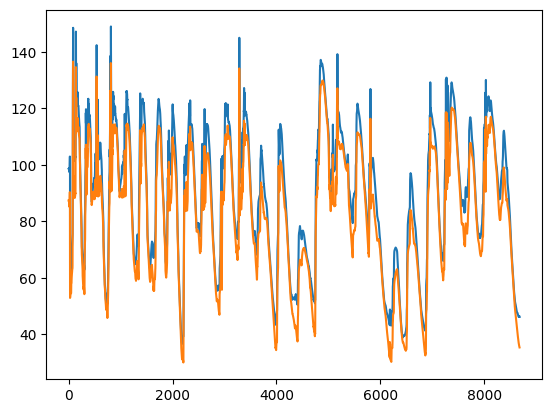

The std is: 4.29


In [235]:
pred_storage = []
for idx in range(ts_observed.shape[0] - 1):
    tmp = ts_observed.iloc[idx,:]
    t   = day_of_year(tmp['date'])
    pred_storage.append(model_inventory(tmp['storage'], model_inflow_forecast(t), 0))
    
observed_storage = ts_observed.storage.values[1:]

plt.plot(pred_storage)
plt.plot(observed_storage)
# tests_gaussian_white_noise(pred_storage - observed_storage)
plt.show()
print('The std is: %.02f' %(np.std(pred_storage - observed_storage)))
inventory_sd = np.std(pred_storage - observed_storage)

In [94]:
def model_inventory_forecast(inventory, inflow, outflow, shock):
    return inventory - outflow + inflow + inventory_sd * shock

### Brownian Motion

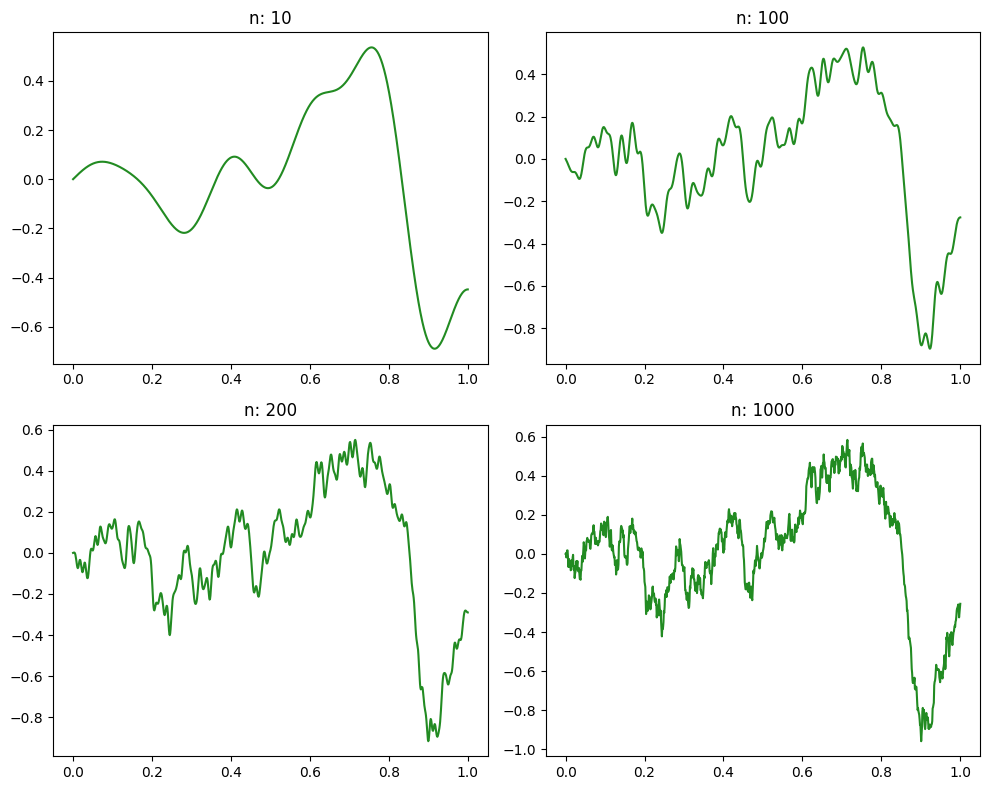

In [33]:
size = 1000
dt = 0.001
times  = np.arange(0,1+dt,dt)
values = np.zeros((size,len(times)))


for idx in range(size):
    n = idx + 1
    xi = np.sqrt(2)*(np.random.randn())/((n+0.5)*np.pi)
    values[idx,:] = xi*np.array([np.sin((n+0.5)*np.pi*t) for t in times])   

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plotted_sizes = [int(size/100), int(size/10), int(size/5), size]

# Iterate over subplots
for i, plot_size in enumerate(plotted_sizes):
    ax = axs[i // 2, i % 2]
    ax.plot(times, values[:plot_size,:].sum(axis=0), color = "forestgreen")
    ax.set_title(f'n: {plot_size}')  # Optional: Set subplot titles

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [82]:
size = 100
dt = 0.001
times  = np.arange(0,1+dt,dt)

def BM(T,n):
    B = np.ones(len(T))*0
    for i in range(n):
        xi = np.sqrt(2)*(np.random.randn())/((i+0.5)*np.pi)
        B = B + xi*np.array([np.sin((i+0.5)*np.pi*t) for t in T])
    return B

def get_statistics(v):
    print(f'Mean: {np.mean(v)}')
    print(f"Std:  {np.std(v)}")

n_sims = 100
sims   = np.zeros((n_sims, len(times)))

for idx in range(n_sims):
    sims[idx,:] = BM(times,size)
    

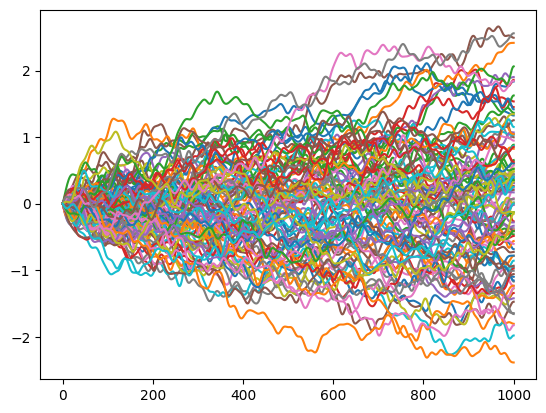

In [83]:
for idx in range(n_sims):
    plt.plot(sims[idx,:])
    
plt.show()

In [116]:
from generate_forecasts import *

In [120]:
ele_ts.iloc[:365*2]

,date,price
hour,,
2015-05-19 00:00:00,2015-05-19 00:27:30,27.930100
2015-05-19 01:00:00,2015-05-19 01:27:30,-12.878828
2015-05-19 02:00:00,2015-05-19 02:27:30,-63.371210
2015-05-19 03:00:00,2015-05-19 03:27:30,-16.610445
2015-05-19 04:00:00,2015-05-19 04:27:30,22.740565
...,...,...
2015-06-18 05:00:00,2015-06-18 05:27:30,27.870129
2015-06-18 06:00:00,2015-06-18 06:27:30,26.182419
2015-06-18 07:00:00,2015-06-18 07:27:30,28.858512


In [40]:
observed_elevation = np.logical_not(np.isnan(ts.elevation.values))
observed_inventory = np.logical_not(np.isnan(ts.storage.values))

observed_values = np.logical_and(observed_inventory, observed_elevation)

elev_inv = zip(ts.storage.values[observed_values], ts.elevation.values[observed_values])
elev_inv = list(elev_inv)
elev_inv = sorted(elev_inv, key = lambda x:x[0])[11:] ## eliminating wrong observations
elev_inv = sorted(elev_inv, key=lambda x: x[1])

n_obs   = len(elev_inv)
n_steps = 5
step    = int(n_obs / n_steps) + 1

thersholds   = []
efficiencies = []
zd = 70
for obs in elev_inv[::step]:
    thersholds.append(obs[0])
    efficiencies.append(obs[1] - zd)

In [43]:
print(np.array(sorted(ts.storage.values[observed_values])[11:]).min())
print(ts.storage.values[observed_values].max())
print(ts.storage.values[observed_values][-1])

26.244
136.521
45.158


In [52]:
ts.outflow.values[np.logical_not(np.isnan(ts.outflow.values))].min()/1e6 * 3600

0.0

In [53]:
ts.outflow.values[np.logical_not(np.isnan(ts.outflow.values))].max()/1e6 * 3600

1.0173671999999998